In [34]:
import pylab as plt 
import numpy as np
import scipy as sp

from Bio.PDB.PDBParser import PDBParser

# from IPython import embed;embed() <- can use this to make breakpoints 

In [35]:
def get_xy_coords_pdb(file_name, structure_id): # Parses pdb file to get xy coordinates of atoms
    parser = PDBParser(PERMISSIVE=1)
    structure = parser.get_structure(structure_id,file_name)
    
    list_of_coords = [atom.get_coord() for atom in structure.get_atoms()]
    
    list_of_coords = np.array(np.delete(list_of_coords, 2, axis=1))
    return list_of_coords

In [36]:
def create_q_vectors(image_size, step_size): # creates 2d array of q_vectors, can specify the step size between vectors
    q_vectors = [] # step_size can also be seen as the resolution of the image !
    
    for x in np.arange(-image_size, image_size+.01, step_size): # can also use linspace instead of arange
        for y in np.arange(-image_size, image_size+.01, step_size):  
            q_vectors.append([x, y])
    return plt.array(q_vectors) 

In [37]:
def create_Tu_vectors(Tu_size):
    Tu = []
    
    for i in range(Tu_size): # Creates Tu vectors ranging from [0,0] to [Tu_size,Tu_size]
        for j in range(Tu_size):
            Tu.append([i,j])
    return plt.array(Tu)

In [38]:
def rotation_matrix(vector,theta): # takes in an atom vector and a theta value (rad), outputs vector that's rotated theta degrees cc
    x_comp, y_comp = vector[0], vector[1]
    rotated_atom = [np.cos(theta)*x_comp - np.sin(theta)*y_comp,
             np.sin(theta)*x_comp + np.cos(theta)*y_comp]
    return rotated_atom

In [39]:
# computing I
def molecular_transform(Q, Atoms,f_j,theta): # takes in a single Q vector and a list of atoms, outputs a single A value
    a = b = 0
    
    for atom in Atoms:
        phase = plt.dot(Q,rotation_matrix(atom,theta)) # to rotate or not to rotate
        #phase = plt.dot(Q,atom)
        a+= plt.cos(phase) # summing real terms 
        b+= plt.sin(phase) # summing imaginary terms
    # computing amplitude
    
    i_real, i_imag = a*f_j, b*f_j
    return i_real + i_imag*1j

def molecular_transform_no_loop(Q,Atoms,f_j,theta): # takes in a single Q vector and a list of atoms, outputs a single A value
    a = b = 0
    rotation_m = [[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]]
    
    rotated_u = np.dot(rotation_m,Atoms.T)
    phase = np.dot(Q, rotated_u)
    a = sum(np.cos(phase))
    b = sum(np.sin(phase))
    i_real, i_imag = a*f_j, b*f_j
    return i_real + i_imag*1j

def molecular_transform_no_loop_array(Qs,Atoms,f_j,theta): # takes in an array of Q instead of a single Q
    a = b = 0
    rotation_m = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    
    rotated_u = np.dot(rotation_m,Atoms.T)
    phase = np.dot(Qs, rotated_u)
    a = np.sum(np.cos(phase), axis = 1) # indicating axis = 1, to sum over the columns instead of rows
    b = np.sum(np.sin(phase), axis = 1)
    i_real, i_imag = a*f_j, b*f_j
    return i_real + i_imag*1j

In [40]:
def lattice_transform(Q, Tu,theta): # takes in a single Q vector and a list of Tu vectors, outputs a single A value
    a = b = 0 
    
    for u in Tu:
        # u is the vector representing the distance between the origin and the corner of a lattice unit
        phase = plt.dot(Q,rotation_matrix(u,theta))
        a+= plt.cos(phase)
        b+= plt.sin(phase)
    i_real, i_imag = a,b
    return i_real + i_imag*1j 

def lattice_transform_no_loop(Q, Tu, theta): # takes in single Q vector and list of Tu vectors, outputs a single A value
    rotation_m = [[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]]
    
    rotated_u = np.dot(rotation_m, Tu.T) # Applying rotation to array of Tu vectors
    phase = np.dot(Q, rotated_u) # applying dot product to a Q vector and rotated Tu vectors
    a = sum(np.cos(phase)) # cosine of phase
    b = sum(np.sin(phase)) # sin of phase
    i_real, i_imag = a, b
    return i_real + i_imag * 1j 

def lattice_transform_no_loop_array(Qs, Tu, theta): # takes in an array of Q instead of a single Q
    rotation_m = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    
    rotated_u = np.dot(rotation_m,Tu.T) 
    phase = np.dot(Qs, rotated_u)  
    a = np.sum(np.cos(phase), axis = 1) # indicating axis = 1, to sum over the columns instead of rows
    b = np.sum(np.sin(phase), axis = 1)

    i_real, i_imag = a, b
    return i_real + i_imag * 1j

In [41]:
def get_I_values(Qs, Atoms, Tu, f_j, theta): # calculating the lattice and molecular transforms and returning intensities
    
    print("Computing intensities")
    
    I_list = []
    for Q in Qs: # for each Q value do these steps! 
        a_molecular = molecular_transform_no_loop(Q,Atoms,f_j,theta) # apply molecular transform! 
        a_lattice = lattice_transform_no_loop(Q,Tu,theta) # apply lattice transform!
        a_total = a_molecular * a_lattice # multiply them together
        final_I = a_total.real**2 + a_total.imag**2 # add the two complex numbers
        I_list.append(final_I) # append that to list
    
    print("Finished intensities")
    
    return np.array(I_list)

def get_I_values_no_loop(Qs, Atoms, Tu, f_j, theta): 
    
    print("Computing intensities")
    
    a_molecular = molecular_transform_no_loop_array(Qs, Atoms, f_j, theta)
    a_lattice = lattice_transform_no_loop_array(Qs, Tu, theta)
    a_total = a_molecular * a_lattice
    
    print("Finished intensities")
    return a_total.real**2 + a_total.imag**2

In [42]:
def add_background_exp(I_list, Qs, a): #add background based on exponential decay
    background_list = []
    
    for q in Qs: 
        x_comp, y_comp = q[0], q[1]
        B = np.exp(-(x_comp**2 + y_comp**2)* a)
        background_list.append(B)
        
    return np.array(background_list) * I_list

In [43]:
def add_background_offset(I_list,a): # adds constant offset to I_list
    return I_list + a

In [44]:
def add_background_gaussian(I_list, mu, sigma): # adds gaussian background to I_list / increase sigma for more background
    gaussian_background_list = np.random.default_rng().normal(mu,sigma,len(I_list))
    return I_list + gaussian_background_list 

In [45]:
def add_background_cauchy(I_list): #doesnt work yet
    cauchy_list = np.random.default_rng().standard_cauchy(len(I_list))
    return cauchy_list + I_list

In [46]:
def show_image(list_of_I_values): # produces image of the resulting array of I values
    print("Showing Image")
    mean = list_of_I_values.mean()
    std = list_of_I_values.std()
    
    vmin = mean - std
    vmax = mean + std 
    
    photo = plt.imshow(list_of_I_values, vmax = vmax, vmin = vmin)
    plt.show()

In [47]:
def add_gaussian_noise(I_list, mu, sigma): # returns the list of I's with gaussian noise multiplied into it 
    gaussian_array = np.random.default_rng().normal(mu, sigma, len(I_list)) 
    noisy_I_list = I_list * gaussian_array
    return noisy_I_list 

In [48]:
def add_poisson_noise(I_list,lam): # returns the list of I's with poisson noise multiplied into it 
    poisson_array = np.random.default_rng().poisson(lam, len(I_list))
    noisy_I_list = I_list * poisson_array
    return noisy_I_list

In [49]:
def add_saltpepper_noise(I_list,noise_level): #returns the list of I's with salt+pepper scattered in it randomly
    
    rng = np.random.default_rng()
    black_or_white = [0,255] # list containing color value for black or white 
    pixel_values = np.array(range((len(I_list)))) # list containing indices of I_list
    
    for i in range(noise_level): 
        rand_index = rng.choice(pixel_values,replace=False) #random generated number with the range of the I_list size 
        I_list[rand_index] = rng.choice(black_or_white)
    return I_list

In [50]:
# find num of spots using ndimage: label and find_objects
def count_spots(I_list,square_I_list): # returns num of peaks and slices indicating the location of peaks
    threshold = square_I_list > I_list.max() * .05 # Threshold is the upper 95% of data
    labels, num_of_labels = sp.ndimage.label(threshold) # Label each index of intensity array based on our defined threshold
    peaks = sp.ndimage.find_objects(labels) # gets tuples corresponding to the location of each peak
    print("Number of spots: " + str(num_of_labels)) 
    return num_of_labels, peaks


In [51]:
image_size = 10 # Parameter - Image Size (for now = 40) 
image_resolution = .2 # Parameter - Step size of image (for now = .5) / went from .5 to .2 to reduce distortion from rotation

Qs = create_q_vectors(image_size, image_resolution)

Qs_size = int(plt.sqrt(len(Qs))) # this gives us the size of the image! eg. 3 -> 3x3 image
Qs_len = len(Qs)

Atoms = plt.array([[1,1.5],[1.5,0],[0,1]]) # Parameter - Atoms
molecule = get_xy_coords_pdb("4bs7.pdb", "4bs7")

f_j = 1

Tu_size = 15 # Parameter - Tu Vectors size 
Tu = create_Tu_vectors(Tu_size)

degrees = 0
theta = degrees * np.pi / 180 # Parameter - theta degrees (rad) to rotate vectors

a = 0 # Parameter - value for the background, decent results are between .001 to .009

I_list = get_I_values_no_loop(Qs, Atoms, Tu, f_j,theta) # Computing intensity values

I_list = add_background_exp(I_list,Qs,a)

square_I_list = plt.reshape(I_list, (Qs_size,Qs_size)) # reshaping list into a square 

spot_count = count_spots(I_list, square_I_list)

Computing intensities
Finished intensities
Number of spots: 9


Showing Image


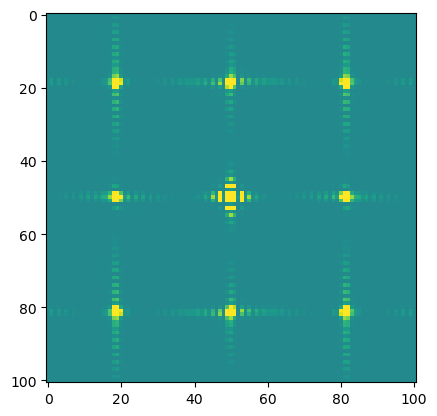

Without vmax and vmin specified: 


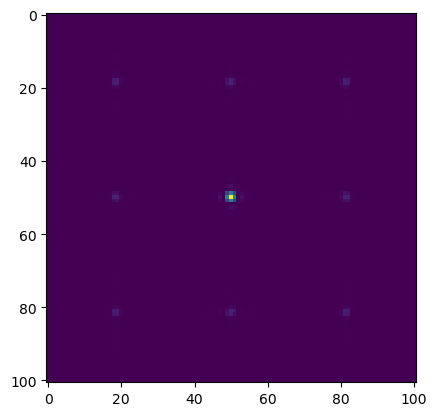

In [52]:
show_image(square_I_list)
plt.imshow(square_I_list)

print("Without vmax and vmin specified: ")
plt.draw()

Showing Image


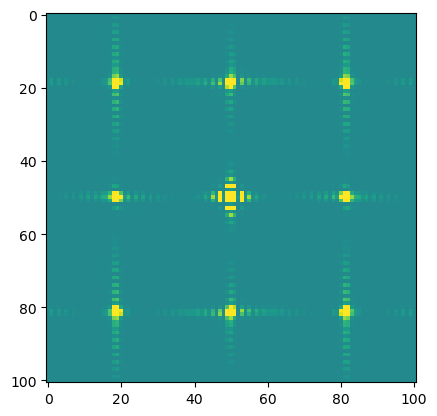

Showing Image


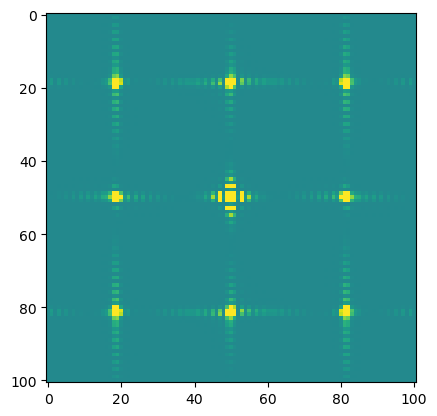

Showing Image


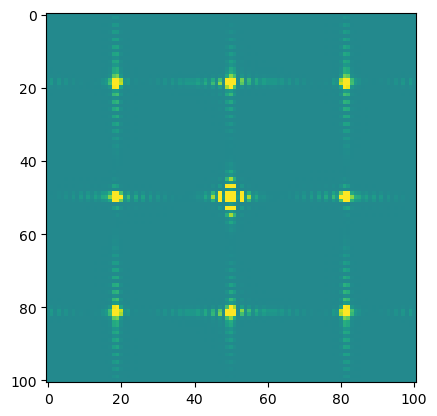

Showing Image


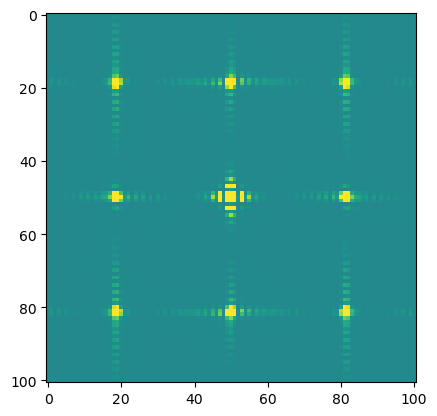

Showing Image


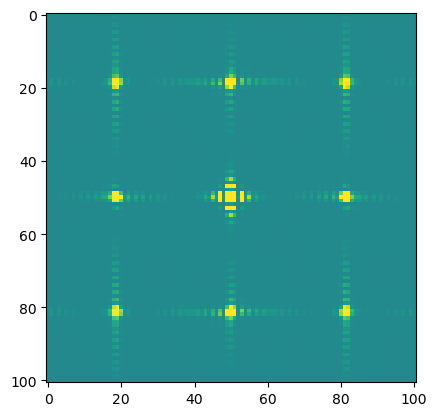

Showing Image


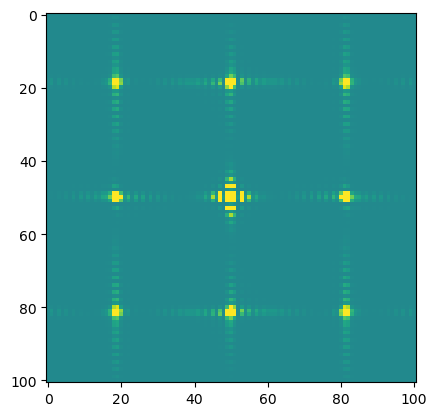

Showing Image


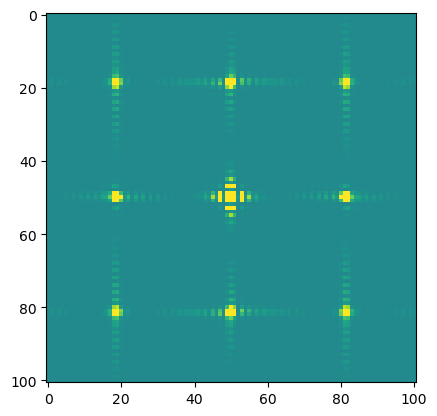

Showing Image


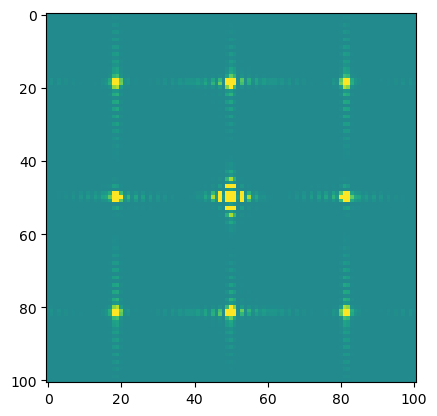

Showing Image


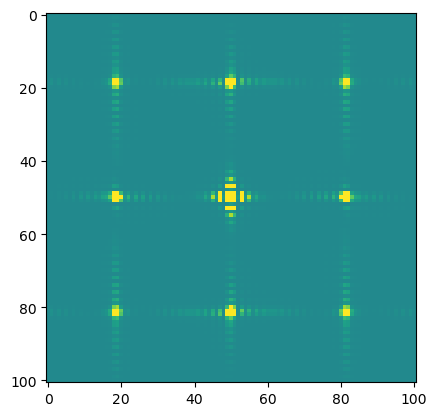

Showing Image


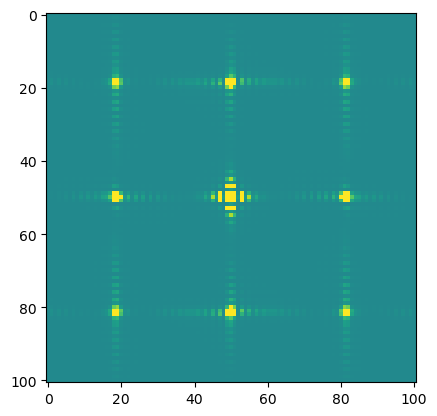

Showing Image


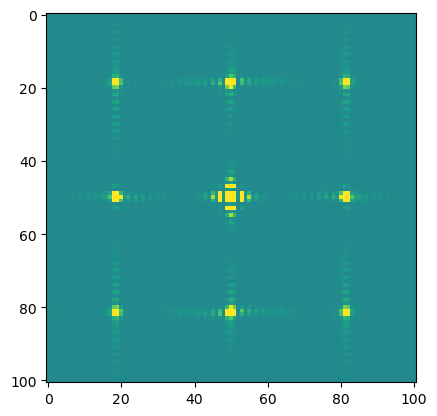

Showing Image


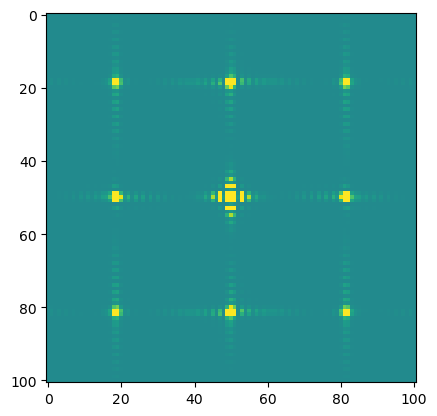

Showing Image


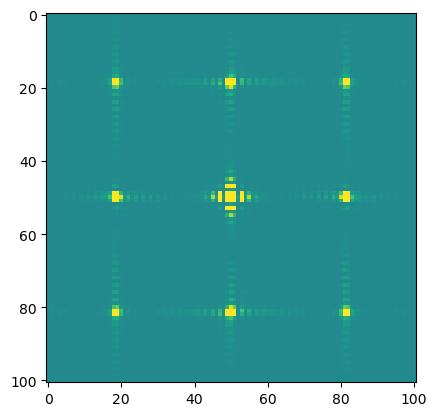

Showing Image


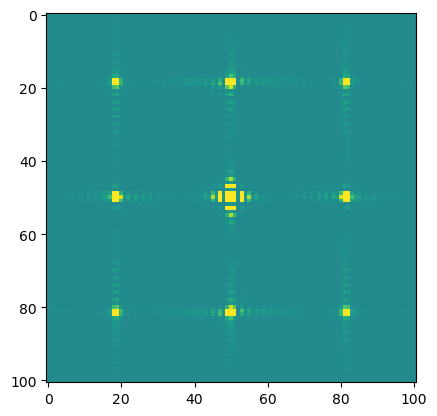

Showing Image


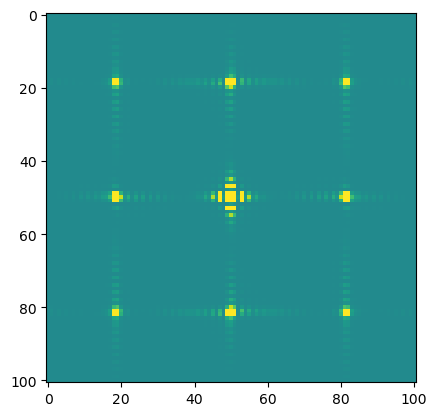

Showing Image


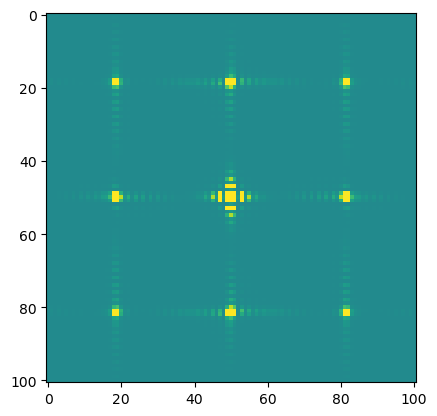

Showing Image


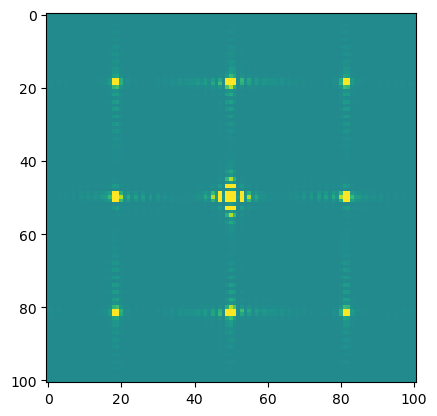

Showing Image


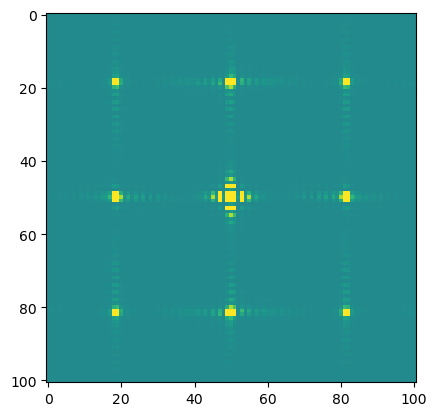

Showing Image


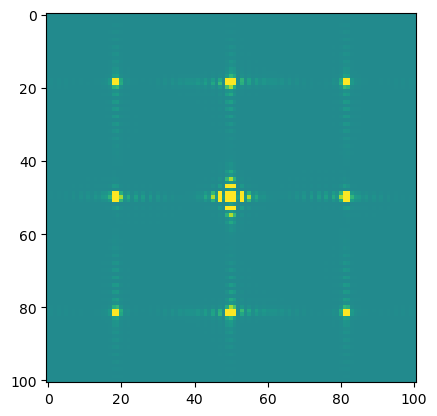

Showing Image


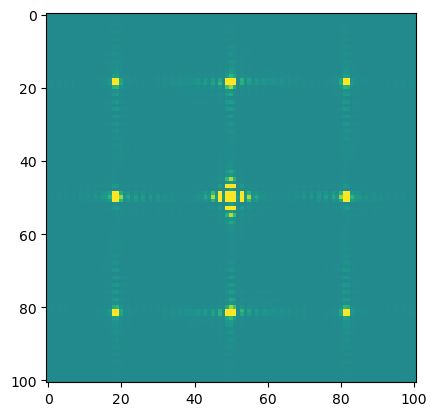

Showing Image


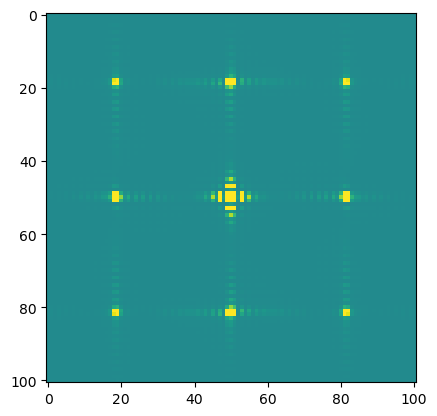

Showing Image


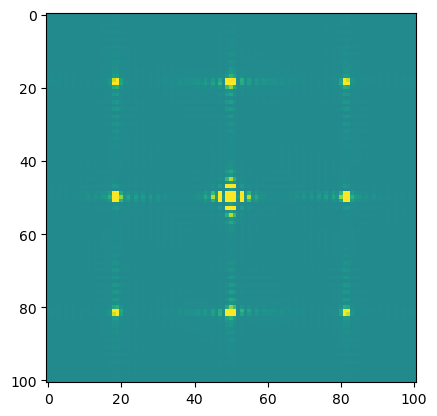

Showing Image


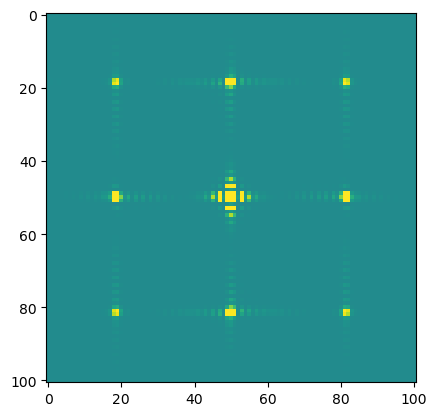

Showing Image


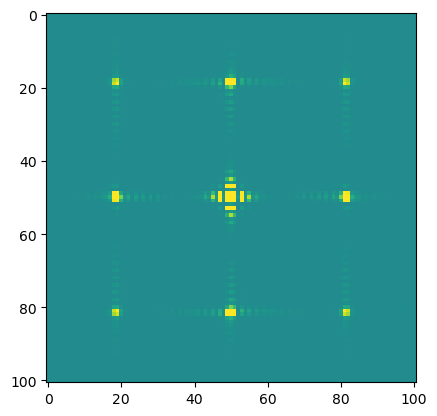

Showing Image


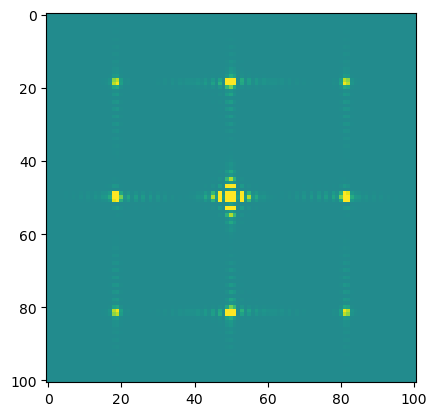

Showing Image


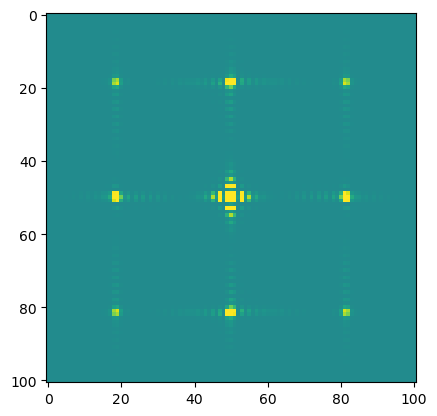

Showing Image


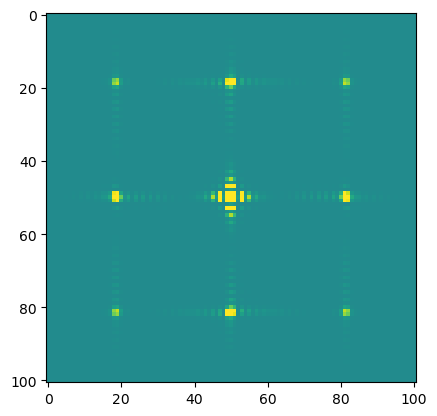

Showing Image


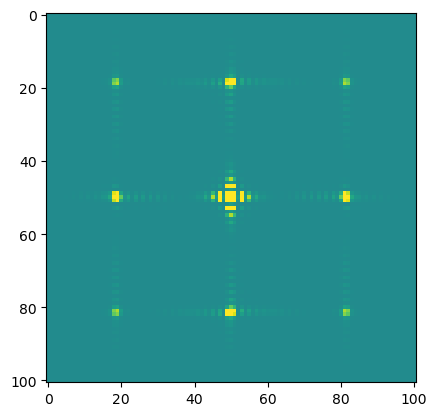

Showing Image


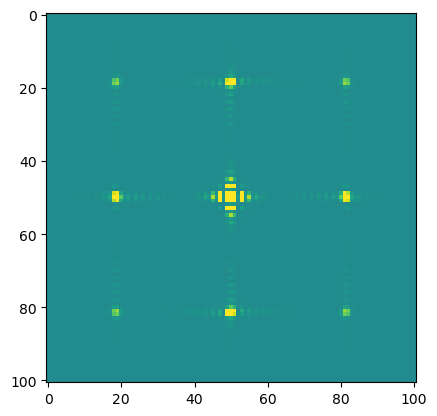

Showing Image


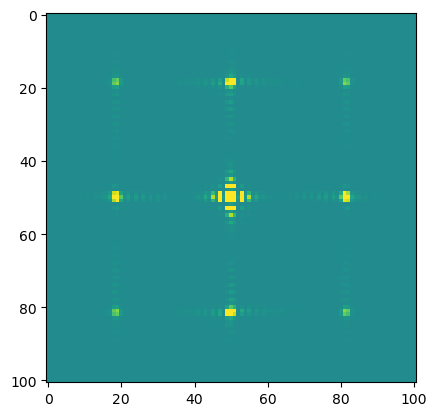

Showing Image


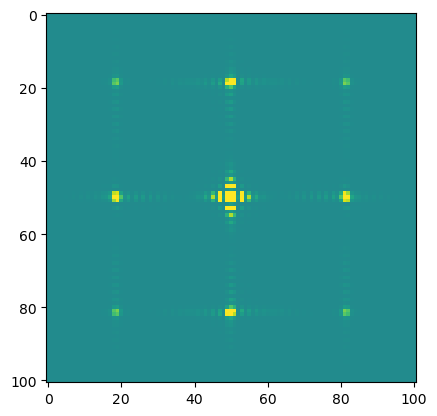

Showing Image


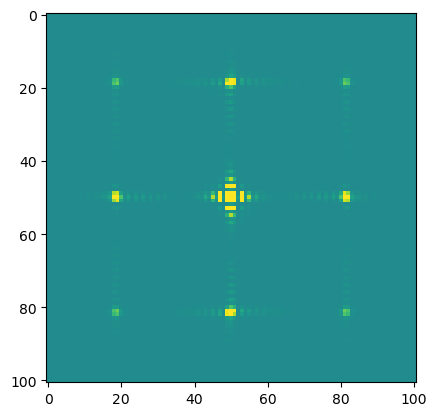

Showing Image


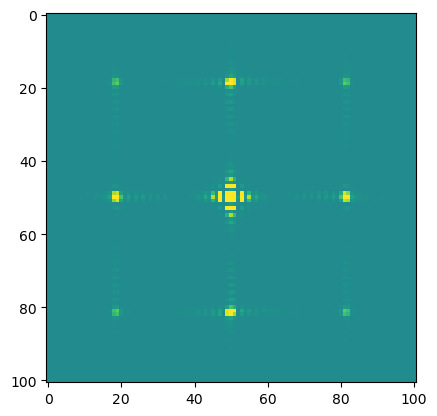

Showing Image


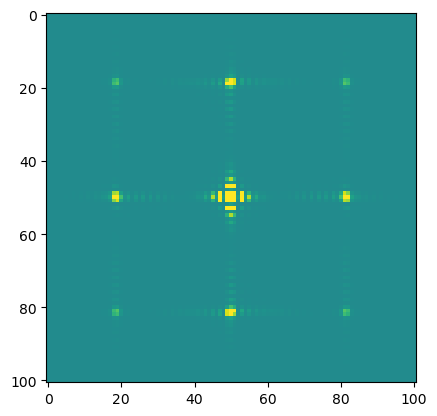

Showing Image


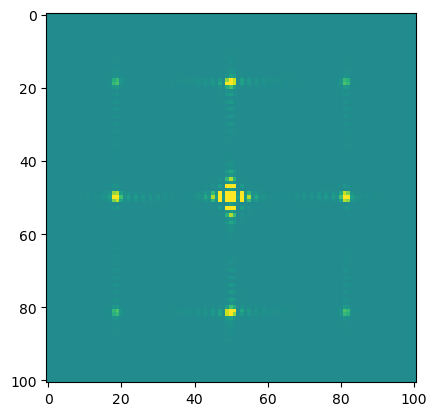

Showing Image


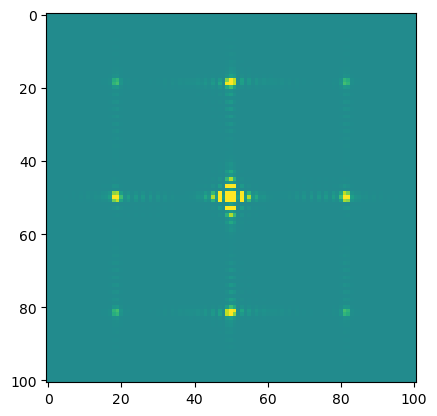

Showing Image


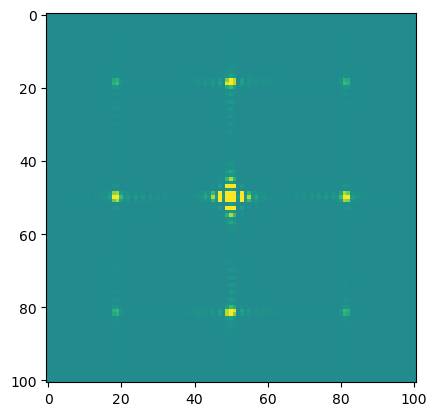

Showing Image


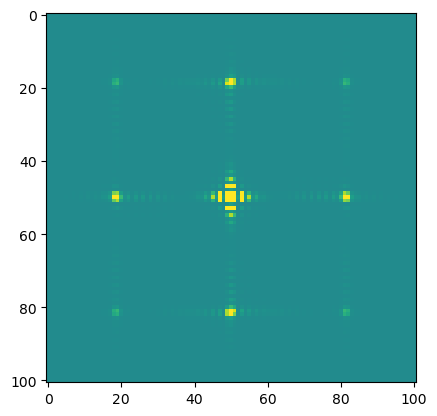

Showing Image


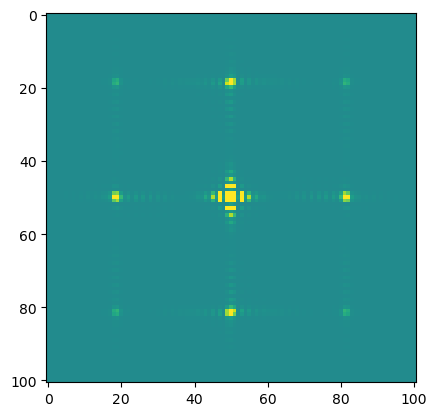

Showing Image


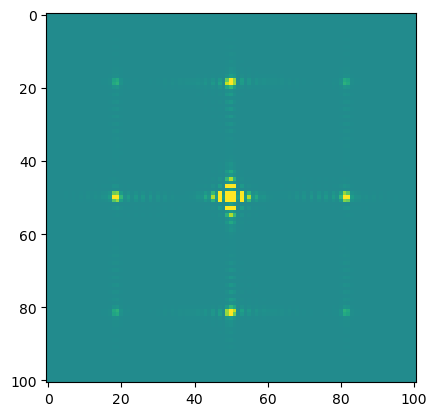

Showing Image


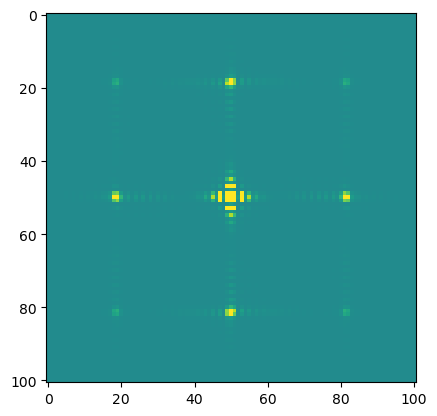

Showing Image


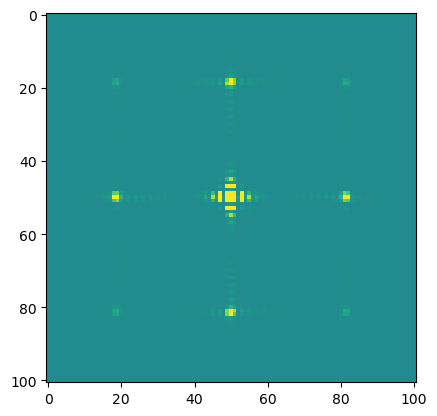

Showing Image


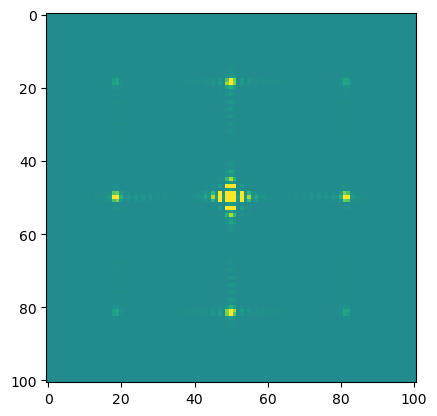

Showing Image


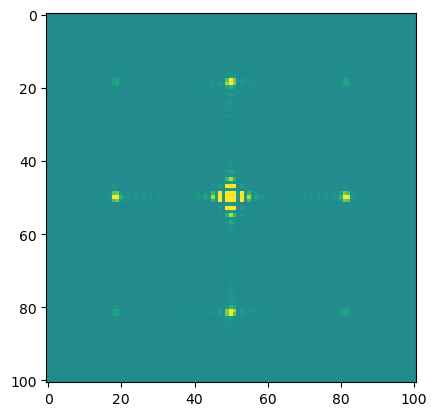

Showing Image


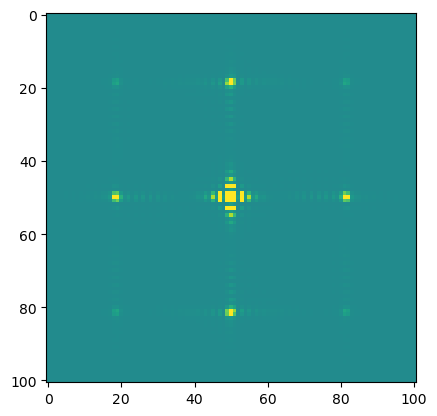

Showing Image


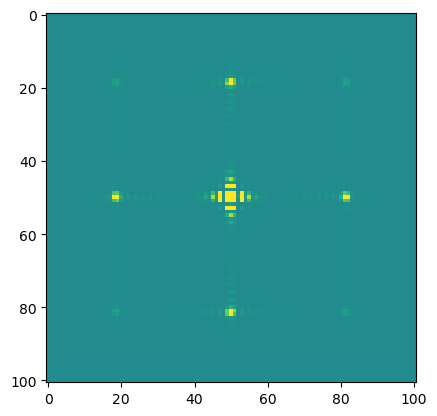

Showing Image


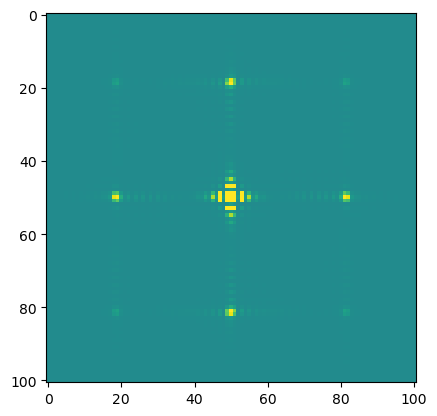

Showing Image


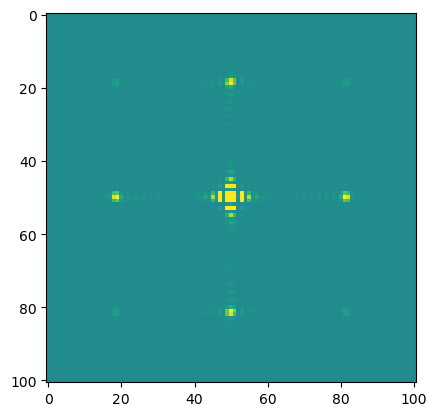

Showing Image


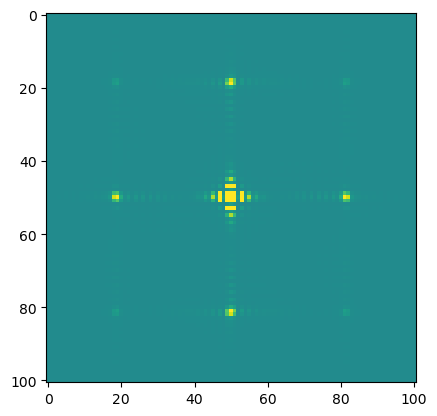

Showing Image


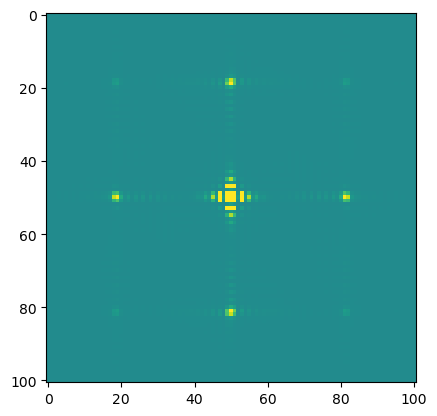

Showing Image


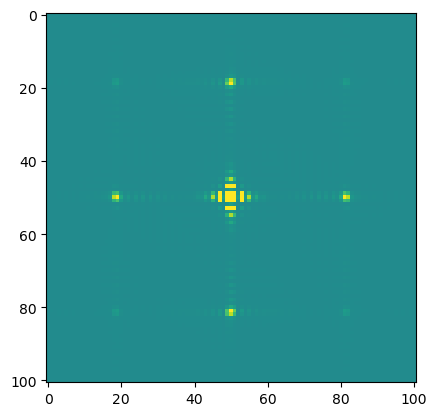

Showing Image


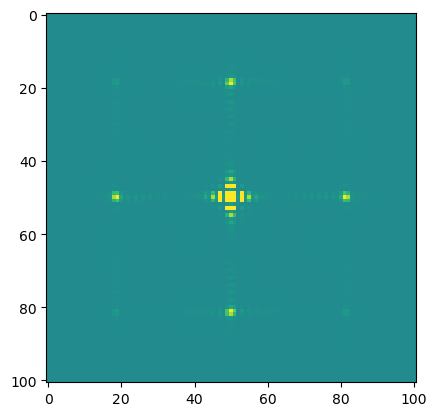

Showing Image


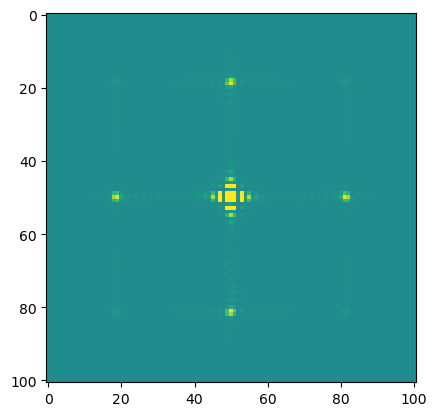

Showing Image


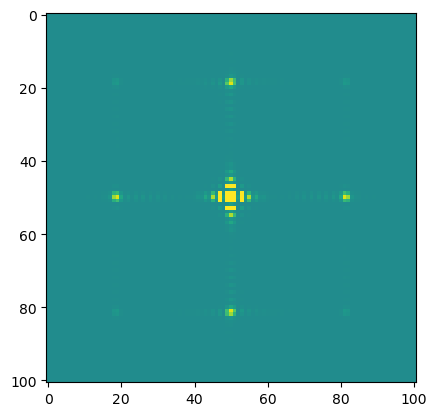

Showing Image


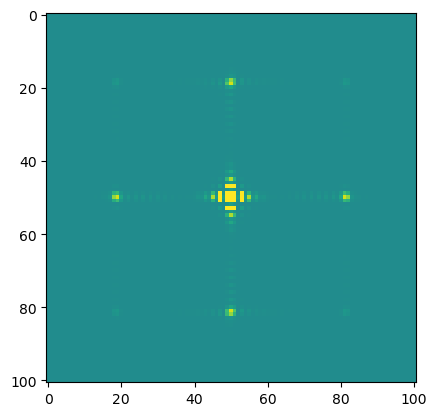

Showing Image


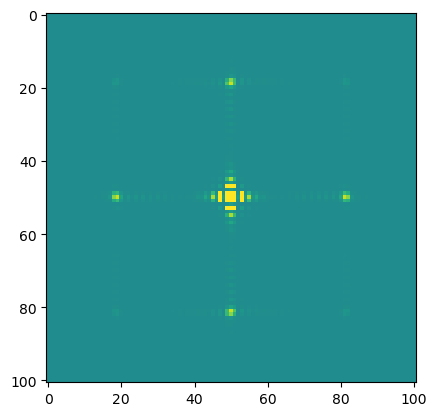

Showing Image


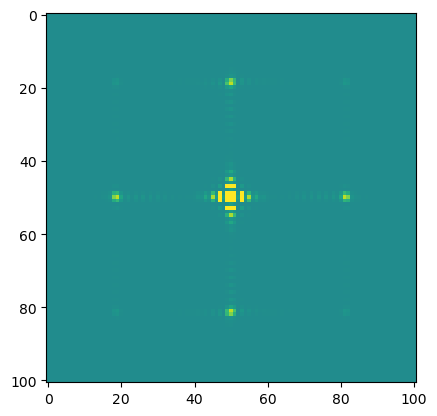

Showing Image


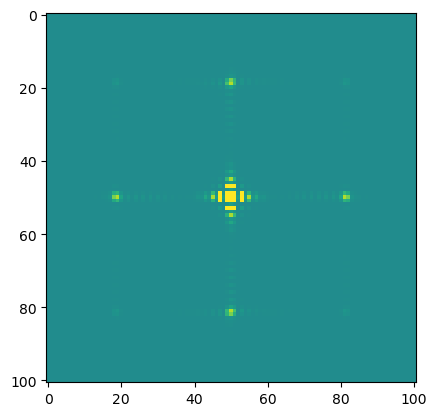

Showing Image


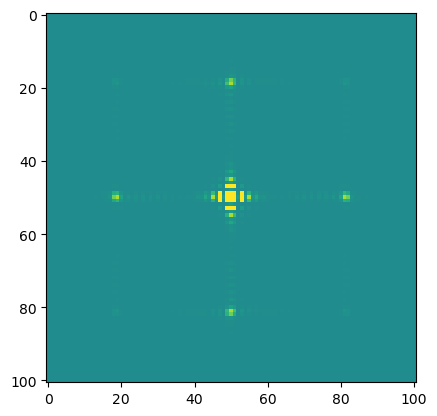

Showing Image


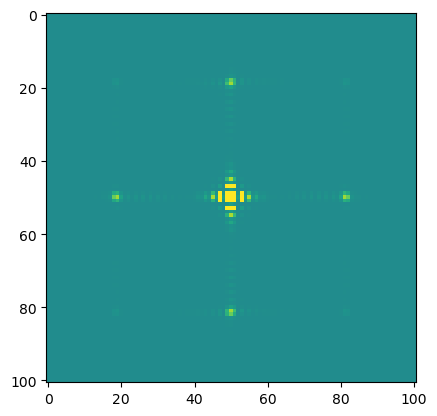

In [53]:
# Background movie! going from a = 0 to 0.06 in steps of .001
for i in np.arange(0,.06,.001):
    a = i 
    I_background_list = add_background_exp(I_list,Qs,a)
    square_I_list = plt.reshape(I_background_list, (Qs_size,Qs_size))
    show_image(square_I_list)

Computing intensities
Finished intensities


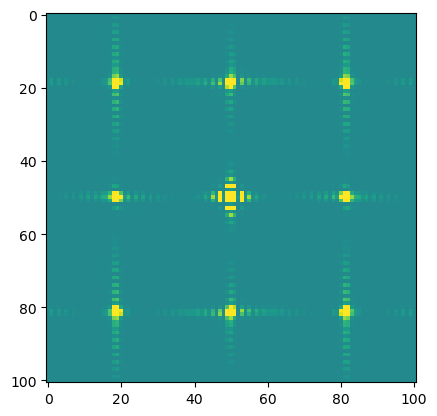

Computing intensities
Finished intensities


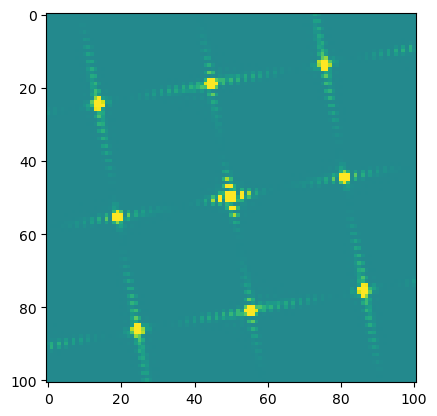

Computing intensities
Finished intensities


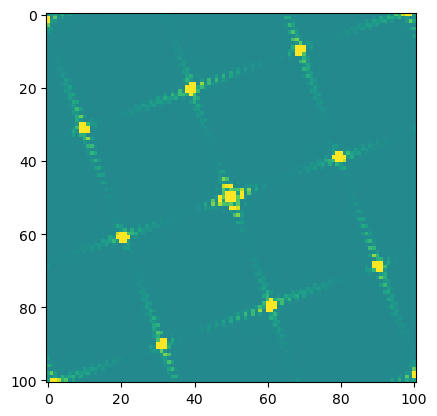

Computing intensities
Finished intensities


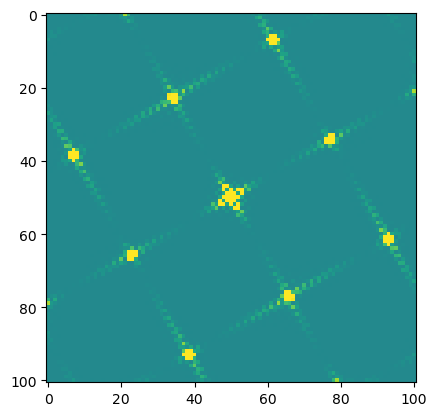

Computing intensities
Finished intensities


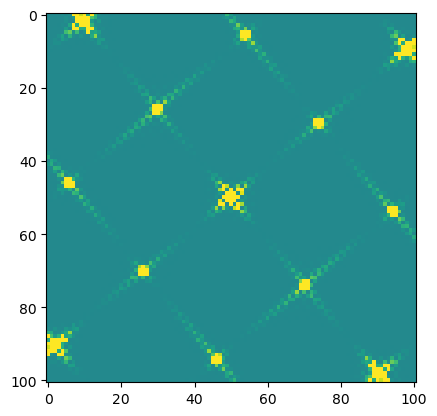

Computing intensities
Finished intensities


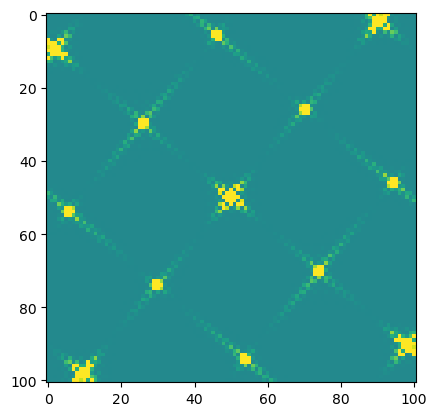

Computing intensities
Finished intensities


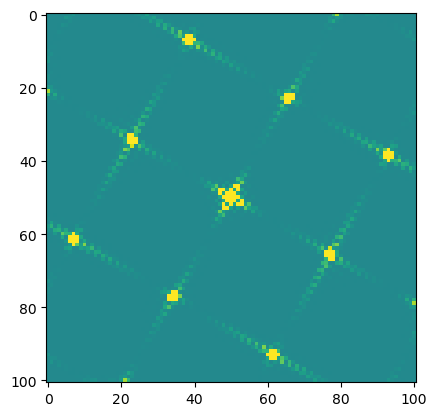

Computing intensities
Finished intensities


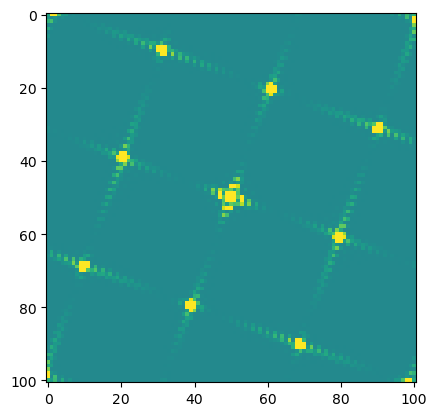

Computing intensities
Finished intensities


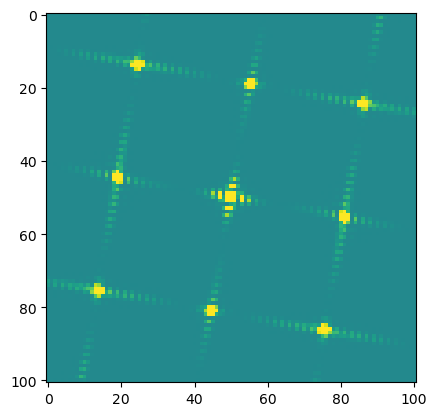

Computing intensities
Finished intensities


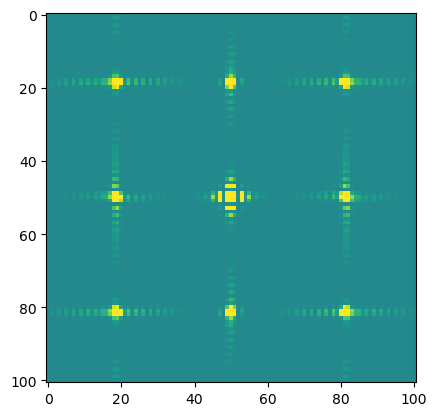

In [54]:
# Rotation movie!  going from 0 to 90 degrees in steps of 10 degrees
for i in np.arange(10): 
    degrees = 10 * i * np.pi / 180
    img = get_I_values(Qs,Atoms,Tu,1,degrees)
    square_I_list = plt.reshape(img, (Qs_size,Qs_size)) 
    plt.imshow(square_I_list, vmax = I_list.mean() + I_list.std(), vmin = I_list.mean() - I_list.std())
    plt.draw
    plt.pause(.5)

In [55]:
#Trying to add noise : have gaussian, poisson, saltpepper so far
mu, sigma = 0, .1 # where mu = mean, and sigma = standard deviation (sigma !< 0)
#gaussian_I_list = add_gaussian_noise(I_list,mu,sigma)

lam = 1 # where lam = average occurences of event within given timeframe
#poisson_I_list = add_poisson_noise(I_list,lam) 

noise_intensity = 6000 # = num of iterations of a random pixel getting replaced
#saltpepper_I_list = add_saltpepper_noise(I_list, noise_intensity) # for some reason this keeps applying to the og list


In [56]:
# print("Size of image is " + str(Qs_size) + " by " + str(Qs_size))
# print("Length of Qs is: " + str(Qs_len))
# print("Gaussian Noise: " + "mu = " + str(mu) + " & sigma = " + str(sigma))
# print("Poisson Noise: " + "lam = " + str(lam))
# print("Salt and Pepper Noise: " + "Noise intensity = " + str(noise_intensity))